# Data Selection

In [1]:
import os
import pandas as pd
import json
import numpy as np
from collections import defaultdict
import random
import networkx as nx
import matplotlib.pyplot as plt

# Select Dataset

In [2]:
# Function to set the dataset paths based on the category
def get_dataset_paths(category):
    base_dir = "../data"
    if category.lower() == "cd_and_vinyl":
        review_file_path = os.path.join(base_dir, "cd_and_vinyl", "CDs_and_Vinyl.jsonl")
        meta_file_path = os.path.join(
            base_dir, "cd_and_vinyl", "meta_CDs_and_Vinyl.jsonl"
        )
    elif category.lower() == "office_products":
        review_file_path = os.path.join(
            base_dir, "office_products", "Office_Products.jsonl"
        )
        meta_file_path = os.path.join(
            base_dir, "office_products", "meta_Office_Products.jsonl"
        )
    else:
        raise ValueError(
            "Invalid category. Choose 'cd_and_vinyl' or 'office_products'."
        )

    return review_file_path, meta_file_path


# Set the category
category = "office_products"  # Change to "office_products" if needed: ["cd_and_vinyl", "office_products"]
review_file_path, meta_file_path = get_dataset_paths(category)

## Load the data

In [3]:
def load_jsonl(file_path, num_rows=None):
    """
    Load a JSONL file into a pandas DataFrame.
    """
    data = []
    with open(file_path, "r") as file:
        for i, line in enumerate(file):
            if num_rows and i >= num_rows:
                break
            data.append(json.loads(line.strip()))
    return pd.DataFrame(data)


# Load review and metadata data
reviews_df = load_jsonl(review_file_path)
meta_df = load_jsonl(meta_file_path)

## Processing

In [4]:
# Filter users with sufficient interactions
min_interactions_per_user = 10
user_interactions_count = reviews_df.groupby("user_id").size()
valid_users = user_interactions_count[
    user_interactions_count >= min_interactions_per_user
].index
filtered_reviews_df = reviews_df[reviews_df["user_id"].isin(valid_users)]

# Group by user-item interactions
user_item_dict = defaultdict(list)
for _, row in filtered_reviews_df.iterrows():
    user_item_dict[row["user_id"]].append(row["asin"])

In [5]:
filtered_reviews_df["parent_asin"] = filtered_reviews_df["asin"]

C:\Users\Matheus\AppData\Local\Temp\ipykernel_19388\3640651603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_df["parent_asin"] = filtered_reviews_df["asin"]


In [6]:
# --- ## 6. Generate sparse and dense subsets with balanced positive and negative interactions ---
def sample_users_and_items_with_balanced_ratings(
    reviews, num_users, num_items, interactions_per_user
):
    """
    Sample users and items ensuring balanced positive and negative ratings.

    Parameters:
    - reviews: DataFrame containing user-item interactions.
    - num_users: Number of users to sample.
    - num_items: Number of items to sample.
    - interactions_per_user: Total number of interactions per user.

    Returns:
    - DataFrame containing sampled interactions.
    """
    # Minimum number of positive and negative interactions per user
    min_positive = interactions_per_user // 2
    min_negative = interactions_per_user // 2

    # Filter users who have both positive and negative ratings
    positive_ratings = reviews[reviews["rating"] >= 3]
    negative_ratings = reviews[reviews["rating"] <= 2]

    valid_users = set(positive_ratings["user_id"]).intersection(
        negative_ratings["user_id"]
    )

    # Sample users from the valid users
    sampled_users = random.sample(list(valid_users), min(len(valid_users), num_users))
    sampled_data = []

    for user in sampled_users:
        user_interactions = reviews[reviews["user_id"] == user]

        # Ensure that we sample balanced positive and negative interactions
        pos_samples = user_interactions[user_interactions["rating"] >= 4].sample(
            min(len(user_interactions[user_interactions["rating"] >= 4]), min_positive)
        )
        neg_samples = user_interactions[user_interactions["rating"] <= 2].sample(
            min(len(user_interactions[user_interactions["rating"] <= 2]), min_negative)
        )

        # Combine positive and negative interactions
        user_sampled_interactions = pd.concat([pos_samples, neg_samples])
        sampled_data.append(user_sampled_interactions)

    # Combine all user interactions
    combined_df = pd.concat(sampled_data)

    # Sample items to control for item count
    sampled_items = combined_df["parent_asin"].value_counts().head(num_items).index
    final_df = combined_df[combined_df["parent_asin"].isin(sampled_items)]

    return final_df


# Generate sparse and dense subsets with balanced positive and negative ratings
sparse_subset = sample_users_and_items_with_balanced_ratings(
    filtered_reviews_df, 100, 1000, 10
)
dense_subset = sample_users_and_items_with_balanced_ratings(
    filtered_reviews_df, 100, 500, 10
)

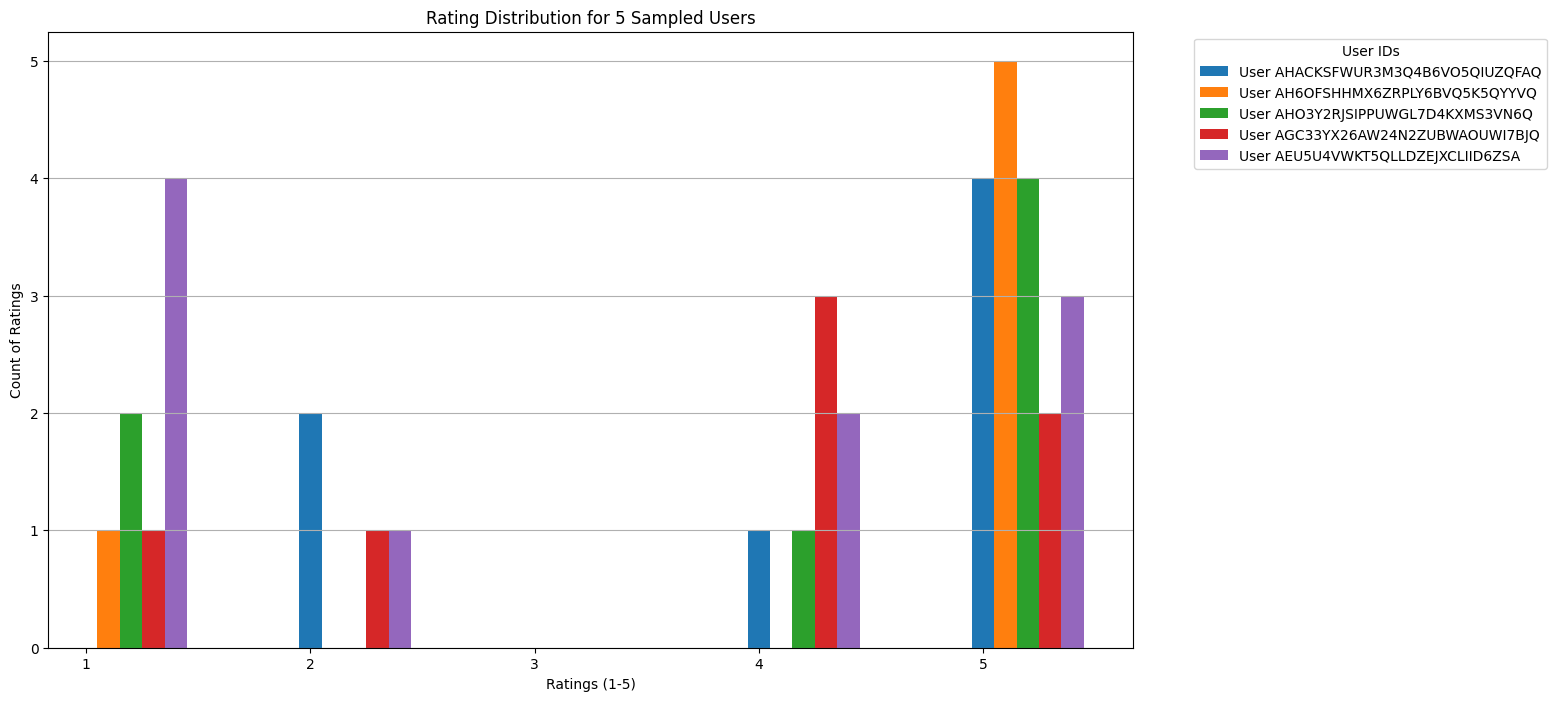

In [7]:
def plot_user_ratings_bar_chart(subset, num_users_to_plot=5):
    """
    Plot the rating distribution of a sample of users from the subset as a bar chart.

    Parameters:
    - subset: DataFrame containing user-item interactions.
    - num_users_to_plot: Number of users to include in the plot.
    """
    sampled_users = subset["user_id"].unique()[:num_users_to_plot]
    plt.figure(figsize=(14, 8))

    for idx, user_id in enumerate(sampled_users):
        user_ratings = (
            subset[subset["user_id"] == user_id]["rating"].value_counts().sort_index()
        )
        plt.bar(
            user_ratings.index + idx * 0.1,
            user_ratings.values,
            width=0.1,
            label=f"User {user_id}",
        )

    plt.title(f"Rating Distribution for {num_users_to_plot} Sampled Users")
    plt.xlabel("Ratings (1-5)")
    plt.ylabel("Count of Ratings")
    plt.xticks(range(1, 6))
    plt.legend(title="User IDs", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, axis="y")
    plt.show()


# Plot the rating distribution for a sample of 5 users from the sparse subset
plot_user_ratings_bar_chart(sparse_subset, num_users_to_plot=5)

Sparse Subset Graph:
Saved sparse graph as PNG to ../data/office_products\sparse_graph.png


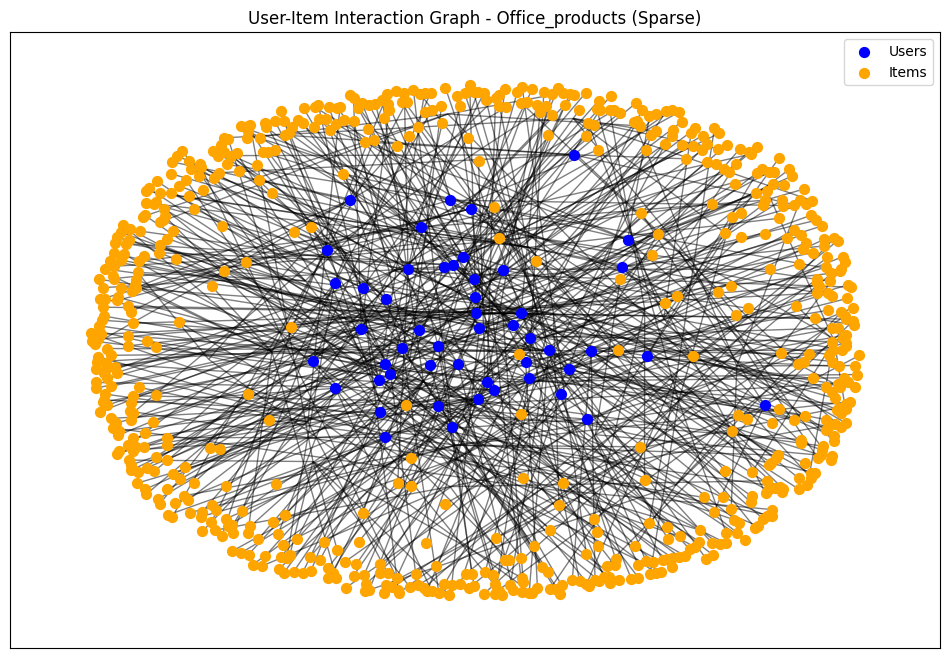


Dense Subset Graph:
Saved dense graph as PNG to ../data/office_products\dense_graph.png


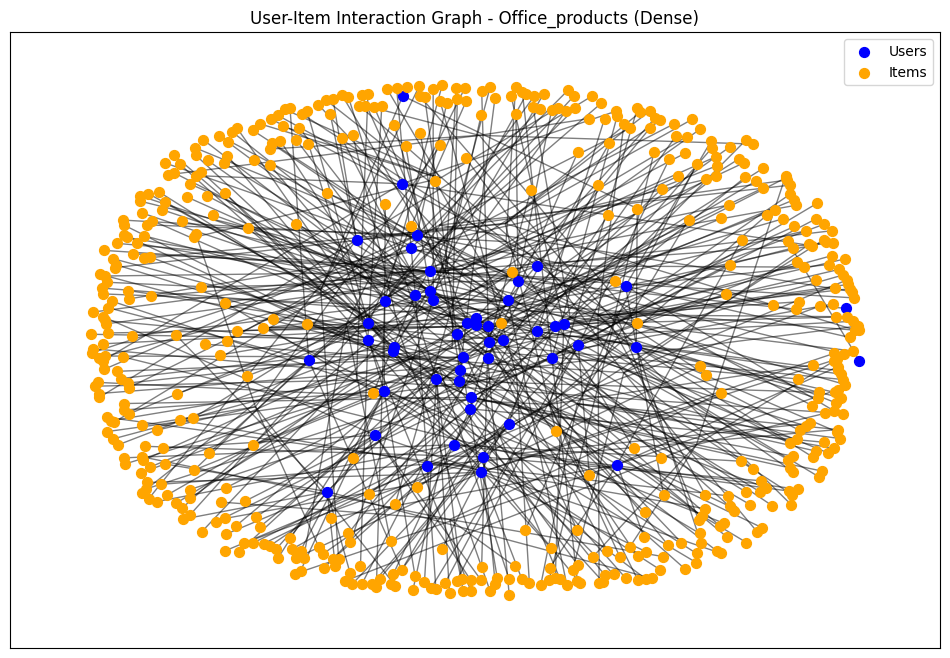

In [8]:
# Create and plot user-item graph
def plot_user_item_graph(
    interactions_df, num_users_to_plot=50, category="", type="sparse"
):
    """
    Plots a user-item interaction graph and saves it as PNG.

    Parameters:
    - interactions_df: DataFrame containing user-item interactions.
    - num_users_to_plot: Number of users to include in the graph for visualization.
    - category: Dataset category (e.g., "cd_and_vinyl", "office_products").
    - type: Subset type ("sparse" or "dense") for naming the graph.
    """
    B = nx.Graph()

    # Nodes
    user_nodes = interactions_df["user_id"].unique()[:num_users_to_plot]
    item_nodes = interactions_df["asin"].unique()

    B.add_nodes_from(user_nodes, bipartite=0, label="users")
    B.add_nodes_from(item_nodes, bipartite=1, label="items")
    edges = list(zip(interactions_df["user_id"], interactions_df["asin"]))
    B.add_edges_from(edges)

    # Layout and plotting
    pos = nx.spring_layout(B, k=0.5)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(
        B, pos, nodelist=user_nodes, node_color="blue", label="Users", node_size=50
    )
    nx.draw_networkx_nodes(
        B, pos, nodelist=item_nodes, node_color="orange", label="Items", node_size=50
    )
    nx.draw_networkx_edges(B, pos, alpha=0.5)

    plt.title(
        f"User-Item Interaction Graph - {category.capitalize()} ({type.capitalize()})"
    )
    plt.legend()

    # Save the plot as PNG
    output_folder = f"../data/{category}"
    os.makedirs(output_folder, exist_ok=True)
    png_path = os.path.join(output_folder, f"{type}_graph.png")
    plt.savefig(png_path)
    print(f"Saved {type} graph as PNG to {png_path}")
    plt.show()


# --- Plot sparse and dense subsets ---
print("Sparse Subset Graph:")
plot_user_item_graph(
    sparse_subset, num_users_to_plot=50, category=category, type="sparse"
)

print("\nDense Subset Graph:")
plot_user_item_graph(
    dense_subset, num_users_to_plot=50, category=category, type="dense"
)

In [9]:
# Save all subsets as CSV
def save_all_subsets(sparse_subset, dense_subset, category):
    """
    Save sparse and dense subsets as CSV files.

    Parameters:
    - sparse_subset: DataFrame containing sparse subset interactions.
    - dense_subset: DataFrame containing dense subset interactions.
    - category: Dataset category (e.g., "cd_and_vinyl", "office_products").
    """
    # Create output folder if it doesn't exist
    output_folder = f"../data/{category}"
    os.makedirs(output_folder, exist_ok=True)

    # Save sparse subset as CSV
    sparse_csv_path = os.path.join(output_folder, "sparse_subset.csv")
    sparse_subset.to_csv(sparse_csv_path, index=False)
    print(f"Saved sparse subset data to {sparse_csv_path}")

    # Save dense subset as CSV
    dense_csv_path = os.path.join(output_folder, "dense_subset.csv")
    dense_subset.to_csv(dense_csv_path, index=False)
    print(f"Saved dense subset data to {dense_csv_path}")


# --- Save CSVs ---
save_all_subsets(sparse_subset, dense_subset, category)

Saved sparse subset data to ../data/office_products\sparse_subset.csv
Saved dense subset data to ../data/office_products\dense_subset.csv
